#4.5

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
  feature_dup_df=feature_dup_df.reset_index()
  new_feature_name_df=pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
  new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0], axis=1)
  new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
  return new_feature_name_df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

def get_human_dataset():

  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
  feature_name_df=pd.read_csv('/content/drive/MyDrive/EURON/test/features.txt',sep='\s+',header=None,names=['column_index','column_name'])

  # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df=get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name=new_feature_name_df.iloc[:,1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
  X_train=pd.read_csv('/content/drive/MyDrive/EURON/test/X_train.txt',sep='\s+',header=None,names=feature_name)
  X_test=pd.read_csv('/content/drive/MyDrive/EURON/test/X_test.txt',sep='\s+',header=None,names=feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train=pd.read_csv('/content/drive/MyDrive/EURON/test/y_train.txt',sep='\s+',header=None,names=['action'])
  y_test=pd.read_csv('/content/drive/MyDrive/EURON/test/y_test.txt',sep='\s+',header=None,names=['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_human_dataset()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

X_train,X_test,y_train,y_test=get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time=time.time()

gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred=gb_clf.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초".format(time.time()-start_time))

GBM 정확도: 0.9379
GBM 수행 시간: 1374.4 초


#4.6

In [ ]:
# !pip install xgboost==1.5.0

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

/usr/local/lib/python3.11/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
import xgboost

print(xgboost.__version__)

1.5.0


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
features=dataset.data
labels=dataset.target

cancer_df=pd.DataFrame(data=features,columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
# !pip install numpy==1.26.4
# !pip install pandas==1.5.3


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label 임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)

# 위에서 만든 X_train,y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

print(X_train.shape,X_test.shape)
print(X_tr.shape,X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [ ]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안 될 경우 X_train.values로 넘파이 변환
# 학습, 검증, 테스트용 DMatrix 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val,label=y_val)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [ ]:
params={'max_depth':3,'eta':0.05,'objective':'binary:logistic','eval_metric':'logloss'}

num_rounds=400

In [ ]:
# 학습 데이터 셋은 'train', 평가 데이터 셋은 'eval'로 명기
eval_list=[(dtr,'train'),(dval,'eval')] # 또는 eval_list=[(dval,'eval)]만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model=xgb.train(params=params,dtrain=dtr,num_boost_round=num_rounds, early_stopping_rounds=50,evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [ ]:
pred_probs=xgb_model.predict(dtest)
print('predcit() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결졍하여 list 객체인 preds에 저장
preds=[1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predcit() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)
  # R0C-AUC 추가
  roc_auc=roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  # R0C-AUC print 추가
  print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율: {2:.4f},F1: {3:.4f},AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [ ]:
get_clf_eval(y_test,preds,pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도:0.9615, 재현율: 0.9740,F1: 0.9677,AUC:0.9937


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

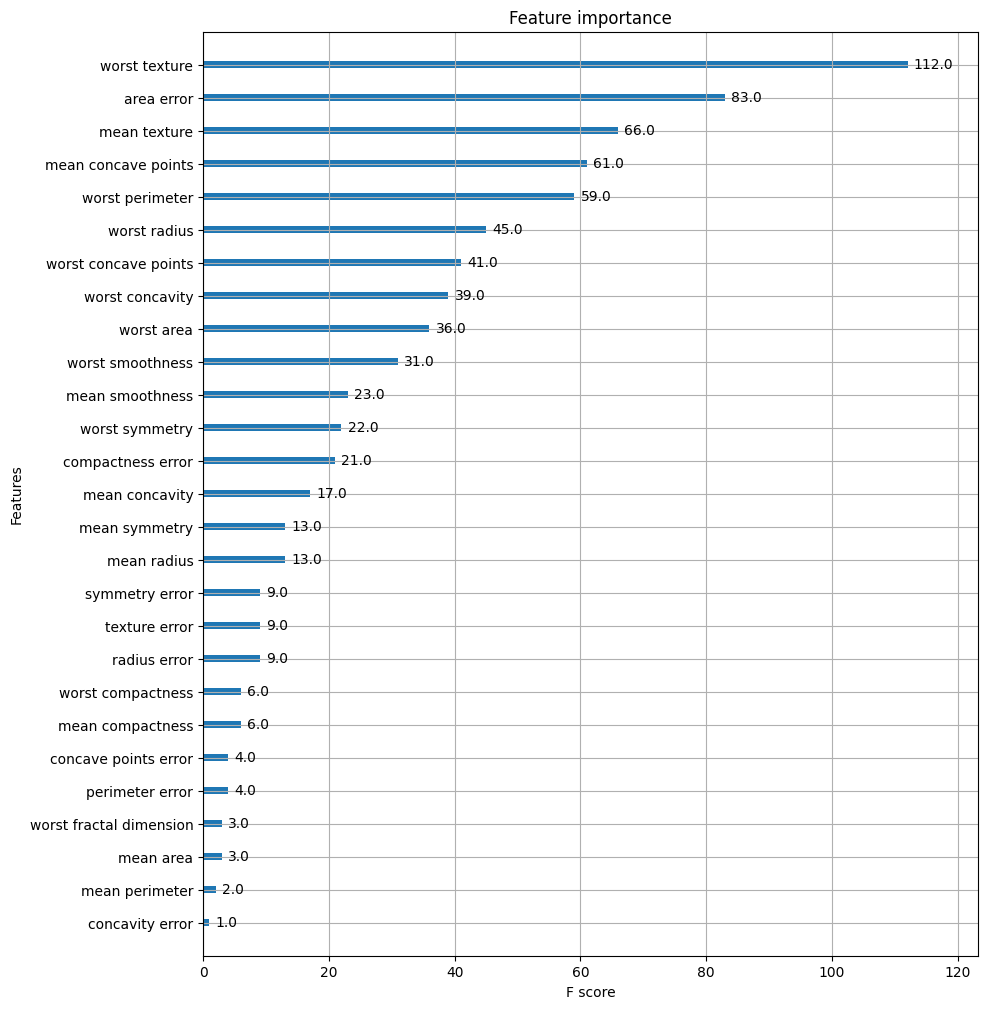

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=3,eval_metric='logloss')
xgb_wrapper.fit(X_train,y_train,verbose=True)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도:0.9620, 재현율: 0.9870,F1: 0.9744,AUC:0.9954


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=3)
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50,eval_metric="logloss", eval_set=evals,verbose=True)

ws50_preds=xgb_wrapper.predict(X_test)
ws50_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [ ]:
get_clf_eval(y_test,ws50_preds,ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도:0.9615, 재현율: 0.9740,F1: 0.9677,AUC:0.9933


In [ ]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_tr,y_tr,early_stopping_rounds=10,eval_metric="logloss",eval_set=evals,verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

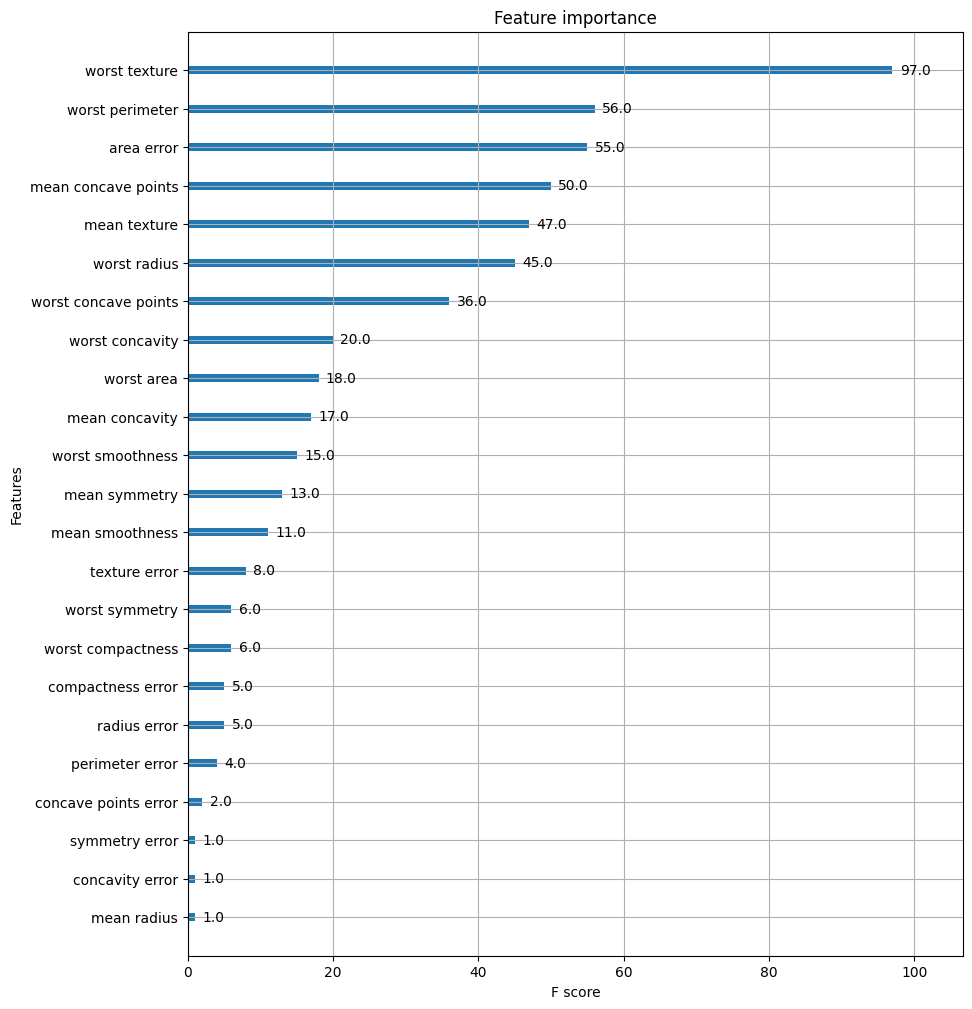

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)

#4.7

In [ ]:
# pip install lightgbm==3.3.2

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()

cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400,learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals=[(X_tr,y_tr),(X_val,y_val)]
lgbm_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50,eval_metric="logloss", eval_set=evals,verbose=True)

preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [ ]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도:0.9615, 재현율: 0.9740,F1: 0.9677,AUC:0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

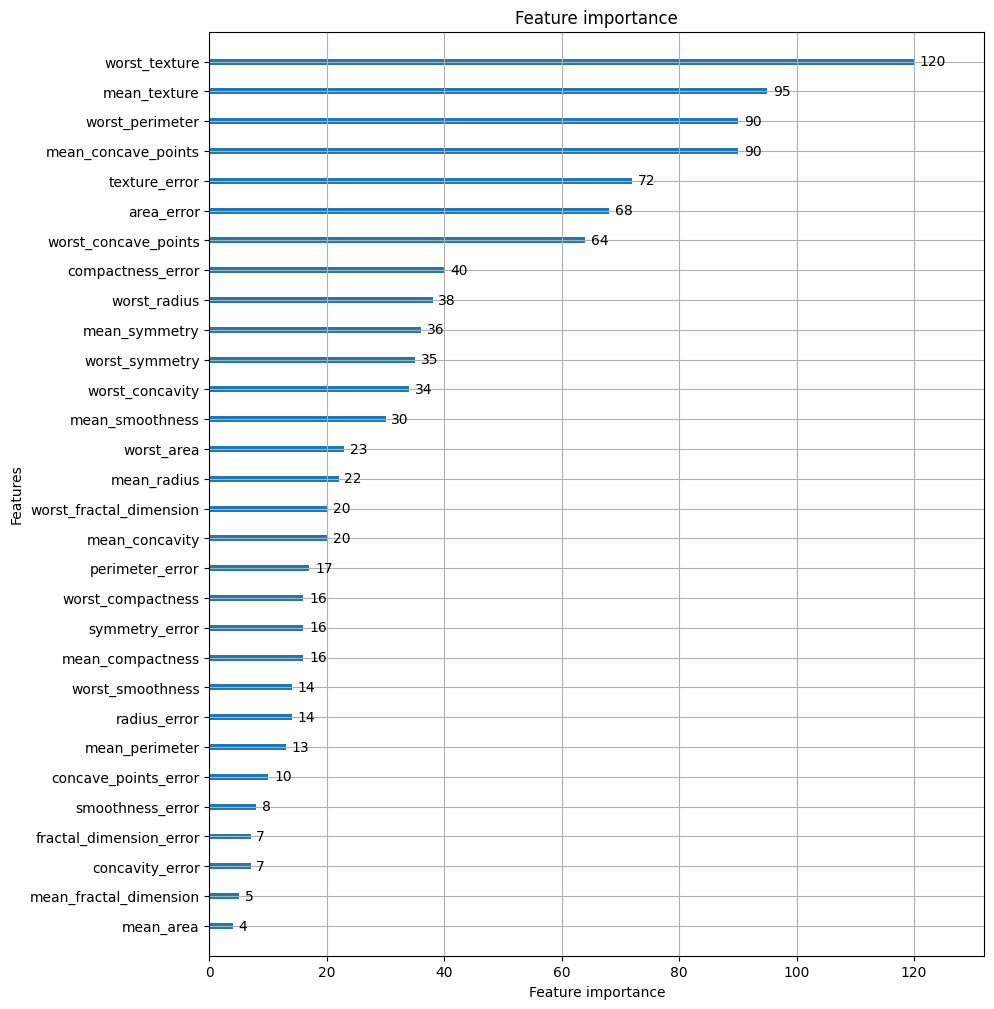

In [ ]:
# plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

#4.8

In [ ]:
params={
    'max_depth':[10,20,30,40,50],'num_leaves':[35,45,55,65], 'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],'subsample':[0.5,0.6,0.7,0.8,0.9],'min_child_weight':[10,20,30,40],'reg_alpha':[0.01,0.05,0.1]
        }

In [ ]:
# pip install hyperopt

In [ ]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정
search_space={'x':hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-1,15,1)}

In [ ]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
  x=search_space['x']
  y=search_space['y']
  retval=x**2-20*y

  return retval

In [ ]:
from hyperopt import fmin, tpe, Trials
# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val=Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도로 찾아냄
best_01=fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=5,trials=trial_val,rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|██████████| 5/5 [00:00<00:00, 681.27trial/s, best loss: -264.0]
best: {'x': -4.0, 'y': 14.0}


In [ ]:
trial_val=Trials()

# max_evals를 20회로 늘려서 재테스트
best_02=fmin(fn=objective_func,space=search_space,algo=tpe.suggest, max_evals=20, trials=trial_val,rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|██████████| 20/20 [00:00<00:00, 579.47trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [ ]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값}와 같은 딕셔너리임
print(trial_val.results)

[{'loss': -164.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': -104.0, 'status': 'ok'}, {'loss': -264.0, 'status': 'ok'}, {'loss': -79.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -120.0, 'status': 'ok'}, {'loss': 41.0, 'status': 'ok'}, {'loss': -76.0, 'status': 'ok'}, {'loss': -80.0, 'status': 'ok'}, {'loss': -120.0, 'status': 'ok'}, {'loss': -159.0, 'status': 'ok'}, {'loss': -99.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': -99.0, 'status': 'ok'}, {'loss': -176.0, 'status': 'ok'}, {'loss': 4.0, 'status': 'ok'}, {'loss': -44.0, 'status': 'ok'}, {'loss': -211.0, 'status': 'ok'}, {'loss': -140.0, 'status': 'ok'}]


In [ ]:
# Trials 객체의 vals 속성에 딕셔너리 형태로 저장됨
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [10.0, 12.0, 6.0, 14.0, 8.0, 15.0, 11.0, 2.0, 7.0, 4.0, 6.0, 8.0, 9.0, 13.0, 9.0, 9.0, -0.0, 3.0, 13.0, 7.0]}


In [ ]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성
losses=[loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df=pd.DataFrame({'x': trial_val.vals['x'],'y': trial_val.vals['y'],'losses':losses})
result_df

,x,y,losses
0,-6.0,10.0,-164.0
1,-4.0,12.0,-224.0
2,4.0,6.0,-104.0
3,-4.0,14.0,-264.0
4,9.0,8.0,-79.0
5,2.0,15.0,-296.0
6,10.0,11.0,-120.0
7,-9.0,2.0,41.0
8,-8.0,7.0,-76.0
9,-0.0,4.0,-80.0


In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

In [ ]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로 min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space={'max_depth':hp.quniform('max_depth',5,20,1),'min_child_weight':hp.quniform('min_child_weight',1,2,1),'learning_rate':hp.uniform('learning_rate',0.01,0.2),'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

In [60]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야함
# 정확도는 높을수록 더 좋은 수치임. -1*정확도를 곱하여 큰 정확도 값일수록 최소가 되도록 변환

def objective_func(search_space):
  # 수행 시간 절약을 위해 nestimators는 100으로 축소
  xgb_clf=XGBClassifier(n_estimators=100,max_depth=int(search_space['max_depth']),min_child_weight=int(search_space['min_child_weight']),learning_rate=search_space['learning_rate'],colsample_bytree=search_space['colsample_bytree'],eval_metric='logloss')
  accuracy=cross_val_score(xgb_clf,X_train,y_train,scoring='accuracy',cv=3)
  # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함
  return {'loss':-1 * np.mean(accuracy),'status':STATUS_OK}


In [ ]:
# !pip uninstall -y scikit-learn
# !pip install --no-cache-dir scikit-learn==1.5.2

In [ ]:
import xgboost
import sklearn
import hyperopt
print(f"xgboost: {xgboost.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"hyperopt: {hyperopt.__version__}")

xgboost: 1.5.0
scikit-learn: 1.5.2
hyperopt: 0.2.7


In [62]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
#fmin() 함수 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [01:23<00:00,  1.66s/trial, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.9599446282177103, 'learning_rate': 0.15480405522751015, 'max_depth': 6.0, 'min_child_weight': 2.0}


In [63]:
print('colsample_bytree:{0},learning_rate={1},max_depth:{2},min_child_weight:{3}'.format(round(best['colsample_bytree'],5),round(best['learning_rate'],5),int(best['max_depth']),int(best['min_child_weight'])))

colsample_bytree:0.95994,learning_rate=0.1548,max_depth:6,min_child_weight:2


In [65]:
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=round(best['learning_rate'],5),max_depth=int(best['max_depth']),min_child_weight=int(best['min_child_weight']), colsample_bytree=round(best['colsample_bytree'],5))
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50,eval_metric='logloss', eval_set=evals, verbose=True)

preds=xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test,preds,pred_proba)

[0]	validation_0-logloss:0.56834	validation_1-logloss:0.60660
[1]	validation_0-logloss:0.47552	validation_1-logloss:0.54538
[2]	validation_0-logloss:0.40208	validation_1-logloss:0.48735
[3]	validation_0-logloss:0.34468	validation_1-logloss:0.45698
[4]	validation_0-logloss:0.29775	validation_1-logloss:0.41730
[5]	validation_0-logloss:0.26004	validation_1-logloss:0.39167
[6]	validation_0-logloss:0.22681	validation_1-logloss:0.36682
[7]	validation_0-logloss:0.20096	validation_1-logloss:0.34593
[8]	validation_0-logloss:0.17763	validation_1-logloss:0.33030
[9]	validation_0-logloss:0.15762	validation_1-logloss:0.31918
[10]	validation_0-logloss:0.14233	validation_1-logloss:0.30772
[11]	validation_0-logloss:0.12769	validation_1-logloss:0.30104
[12]	validation_0-logloss:0.11566	validation_1-logloss:0.29621
[13]	validation_0-logloss:0.10479	validation_1-logloss:0.29157
[14]	validation_0-logloss:0.09640	validation_1-logloss:0.28495
[15]	validation_0-logloss:0.08707	validation_1-logloss:0.28055
[1

#4.10

In [66]:
# !pip install imbalanced-learn

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df=pd.read_csv('/content/drive/MyDrive/EURON/test/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [68]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

In [69]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy=get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할, stratify=y_target으로 Stratified 기반 분할
  X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

In [70]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [71]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression(max_iter=1000)
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85280    15]
 [   56    92]]
정확도: 0.9992, 정밀도:0.8598, 재현율: 0.6216,F1: 0.7216,AUC:0.9738


In [72]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test,pred,pred_proba)

In [73]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도:0.9573, 재현율: 0.7568,F1: 0.8453,AUC:0.9790


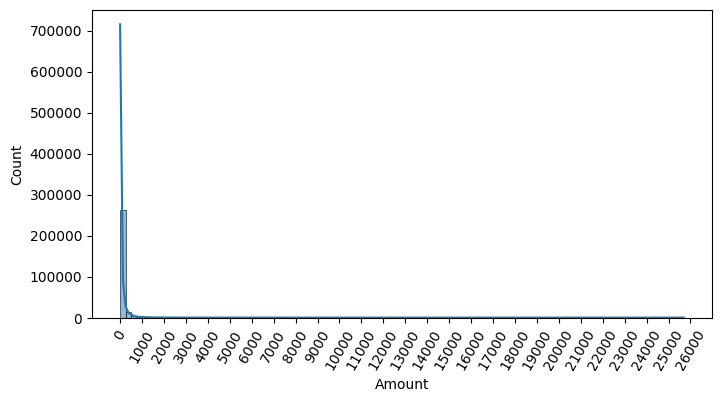

In [74]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'],bins=100,kde=True)
plt.show()

In [75]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_scaled로 피처명 변경후 DataFrame맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [76]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도:0.8692, 재현율: 0.6284,F1: 0.7294,AUC:0.9706
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도:0.9569, 재현율: 0.7500,F1: 0.8409,AUC:0.9779


In [77]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  # 넘파이의 log1p()를 이용해 amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [78]:
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도:0.8725, 재현율: 0.6014,F1: 0.7120,AUC:0.9734
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도:0.9576, 재현율: 0.7635,F1: 0.8496,AUC:0.9796


<Axes: >

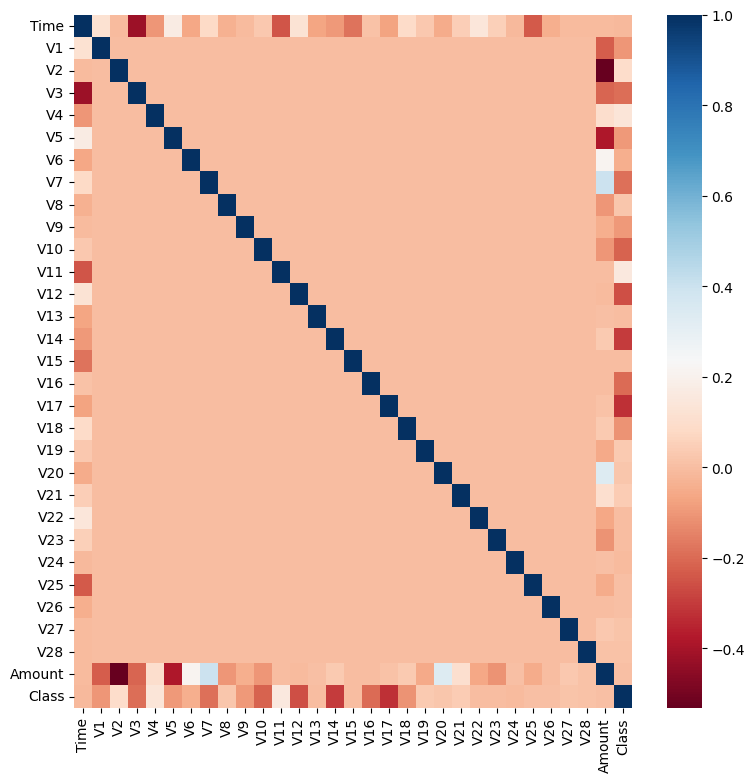

In [79]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [80]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)

  # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr=quantile_75 - quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index=fraud[(fraud < lowest_val)| (fraud > highest_val)].index
  return outlier_index

In [81]:
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [82]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도:0.8673, 재현율: 0.6712,F1: 0.7568,AUC:0.9725
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도:0.9603, 재현율: 0.8288,F1: 0.8897,AUC:0.9780


In [83]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',X_train.shape,y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:',X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [84]:
lr_clf=LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도:0.0541, 재현율: 0.9247,F1: 0.1022,AUC:0.9736


In [87]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

%matplotlib inline

def precision_recall_curve_plot(y_test,pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds=precision_recall_curve(y_test,pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
  plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start,end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

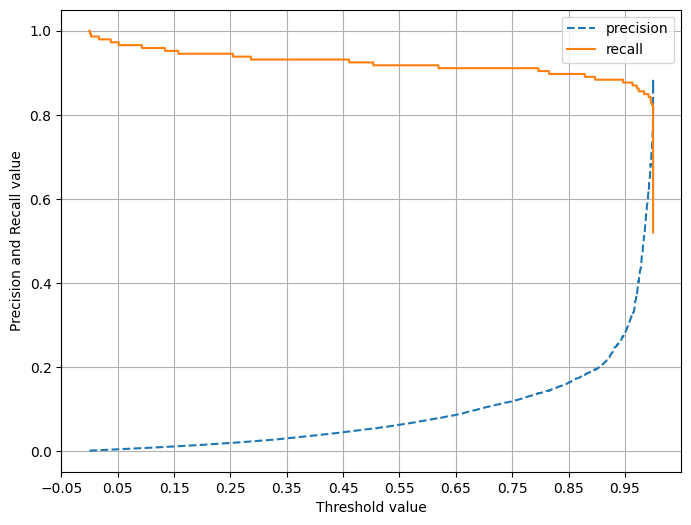

In [88]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [89]:
lgbm_cf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도:0.9118, 재현율: 0.8493,F1: 0.8794,AUC:0.9814


#4.11

In [90]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train,X_test,y_train,y_test=train_test_split(X_data,y_label,test_size=0.2,random_state=0)


In [91]:
# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression()

In [92]:
# 개별 모델들을 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [93]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정트리 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [94]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [95]:
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도: 0.9737


In [102]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  # 지정된 n_folds값으로 KFold 생성
  kf=KFold(n_splits=n_folds,shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터의 반환을 위한 넘파이 배열 초기화
  train_fold_pred=np.zeros((X_train_n.shape[0],1))
  test_pred=np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index,valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트:', folder_counter,'시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr,y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:,folder_counter]=model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean


In [103]:
knn_train,knn_test=get_stacking_base_datasets(knn_clf,X_train,y_train,X_test,7)
rf_train,rf_test=get_stacking_base_datasets(rf_clf,X_train,y_train,X_test,7)
dt_train,dt_test=get_stacking_base_datasets(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test=get_stacking_base_datasets(ada_clf,X_train,y_train,X_test,7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작


In [104]:
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,'스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [105]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도: 0.587719
